# [LAB 10] 07.대응표본 T TEST 연습문제 풀이


| 표본 유형            | 정규성  | 등분산성 | 사용해야 하는 검정                    |
|----------------------|---------|-----------|----------------------------------------|
| 단일표본            | ✓ 총족  | –         | One-sample t-test                      |
| 단일표본            | ✗ 불충족 | –         | Wilcoxon signed-rank test              |
| 독립표본            | ✓ 총족  | ✓ 총족    | Student’s independent t-test           |
| 독립표본            | ✓ 총족  | ✗ 불충족  | Welch’s t-test                         |
| 독립표본            | ✗ 불충족 | –         | Mann–Whitney U test                    |
| 대응표본(쌍체표본)   | ✓ 총족  | –         | Paired t-test                          |
| 대응표본(쌍체표본)   | ✗ 불충족 | –         | Wilcoxon signed-rank test              |

※ 단일 표본, 대응 표본은 등분산성 개념이 없음


### 준비작업
#### 패키지 참조

In [1]:
from hossam import load_data
from pandas import DataFrame, melt, pivot_table
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
from math import sqrt
from scipy.stats import t, normaltest, bartlett, levene, ttest_rel,mannwhitneyu, wilcoxon
from statannotations.Annotator import Annotator
from IPython.display import display

#### 그래프 초기화

In [2]:
#한글을 지원하는 폰트 파일의 경로
font_path ='C:\\Data_Analysis_Basic\\[LAB-06] 데이터 시각화 개요\\NotoSansKR-Regular.ttf'
#폰트의 그룹을 시스템에 등록
fm.fontManager.addfont(font_path)
#폰트의 속성을 읽어옴
font_prop = fm.FontProperties(fname=font_path)
#읽어온 속성에서 폰트의 이름만 추출
font_name = font_prop.get_name()

#이미지의 선명도를 결정 (1인치 당 픽셀의 수)
my_dpi = 120 
#시스템에 등록된 글꼴 이름  (상단에서 확인한 폰트 이름으로 넣기)
my_font_name = 'Noto Sans KR'
#그림 스타일 지정
my_theme = 'dark'
#seaborn 스타일 (화풍 설정하기)
sb.set_theme(style=my_theme)
#그래프에 한글 폰트 적용
plt.rcParams['font.family']=my_font_name
#기본 폰트 크기
plt.rcParams['font.size'] =16
#그래프에 마이너스 꺠짐 방지 (한글환경에서 필수)
plt.rcParams['axes.unicode_minus']=False

### 문제 1

#### 1. 데이터 가져오기
- blood_pressure 데이터셋은 부인 15명을 대상으로 평상시 혈압을 측정한 뒤, 이들에게 이 피임약을 일정 기간 복용하게 한 후 이들의 혈압을 다시 측정한 결과를 기록한 데이터이다.
- 이 데이터를 통해 피임약 복용이 혈압에 영향을 주는지 분석하라.

In [3]:
origin = load_data('blood_pressure')

print("\n=====   데이터 크기 확인   =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

print("\n=====   타입확인   =====")
print(origin.info())

origin.head()


[data] https://data.hossam.kr/data/lab10_/blood_pressure.xlsx
[desc] 부인 15명을 대상으로 평상시 혈압을 측정한 뒤, 이들에게 이 피임약을 일정 기간 복용하게 한 후 이들의 혈압을 다시 측정한 결과를 기록한 데이터 (출처: 방송통신대학교 통계학개론)
[!] Cannot read metadata

=====   데이터 크기 확인   =====
데이터셋 크기: (15, 2)
열 개수: 2
행 개수: 15

=====   타입확인   =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   복용전     15 non-null     int64
 1   복용후     15 non-null     int64
dtypes: int64(2)
memory usage: 372.0 bytes
None


,복용전,복용후
0,70,68
1,80,72
2,72,62
3,76,70
4,76,58


#### 2.데이터 분포,신뢰수준 시각화 + 가설검정 가정 확인 

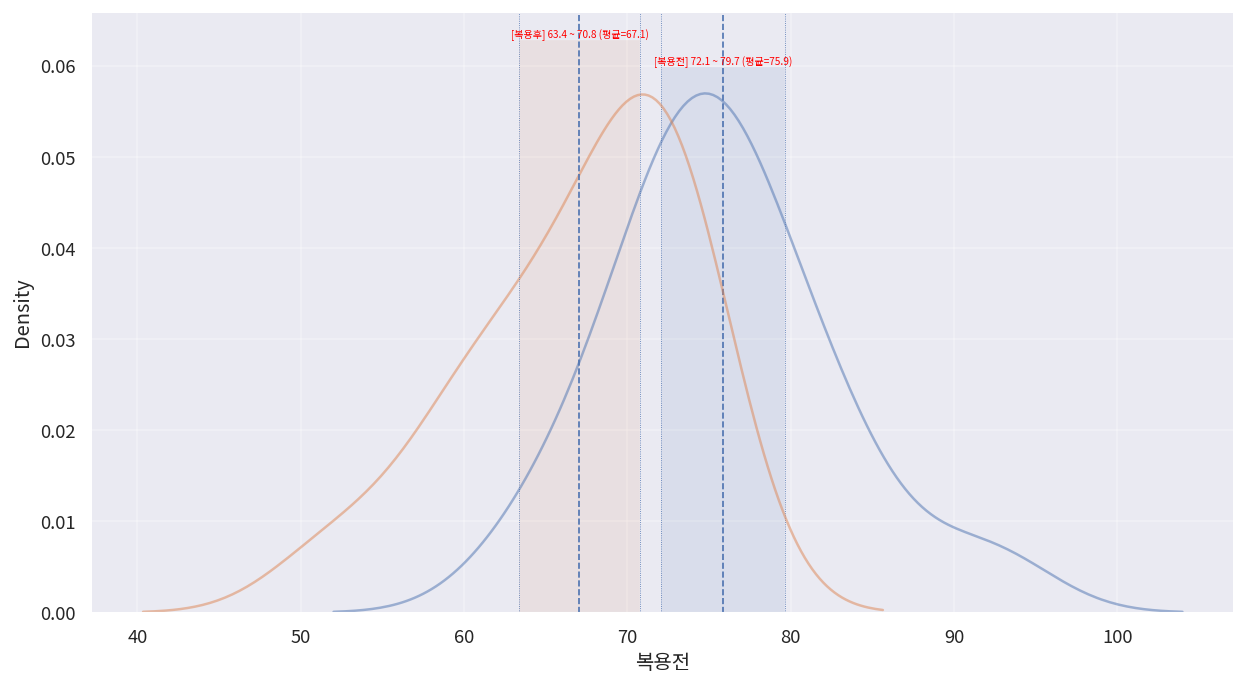

,statistic,p-value,result
field,,,
복용전,2.590682,0.273805,True
복용후,2.656338,0.264962,True
Bartlett,1.013185,0.314141,True


In [4]:

# -----------------------------------------
# 분석할 두 변수만 추출
# -----------------------------------------
data = origin[['복용전', '복용후']]   # 확인할 데이터


# -----------------------------------------
# 데이터 분포 / 신뢰구간 시각화
# -----------------------------------------

# 1) 그래프 초기화
width_px = 1280        # 그래프 가로크기
height_px = 720        # 그래프 세로크기
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) 각 변수에 대해 KDE + 신뢰구간 그리기
for c in data.columns:
    
    # KDE Plot
    sb.kdeplot(data=data, x=c, fill=False, alpha=0.5)

    # 신뢰구간 계산
    max_v = data[c].max()
    clevel = 0.95
    dof = len(data[c]) - 1
    sp_mean = data[c].mean()
    sp_std = data[c].std(ddof=1)
    sp_std_error = sp_std / sqrt(len(data[c]))

    cmin, cmax = t.interval(
        clevel,
        dof,
        loc=sp_mean,
        scale=sp_std_error
    )

    # 신뢰구간 표시
    ax.axvline(cmin, linestyle=':', linewidth=0.5)
    ax.axvline(cmax, linestyle=':', linewidth=0.5)

    # 평균 표시
    ymin, ymax = ax.get_ylim()
    ax.fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax.axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트로 표시
    ax.text(
        x=(cmax-cmin)/2 + cmin,
        y=ymax,
        s=f"[{c}] {cmin:.1f} ~ {cmax:.1f} (평균={sp_mean:.1f})",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"size": 6, "color": "red"}
    )

# 그래프 꾸미기
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()


# -----------------------------------------
# 가설검정 (정규성 → 등분산성)
# -----------------------------------------
equal_var_fields = []
normal_dist = True
report = []

# 1) 정규성 검정
for c in data.columns:
    s, p = normaltest(data[c])
    normalize = p > 0.05   # 정규성 만족 여부

    report.append({
        "field": c,
        "statistic": s,
        "p-value": p,
        "result": normalize
    })

    normal_dist = normal_dist and normalize   # 모두 만족해야 True


# 2) 등분산성 검정
if len(data.columns) > 1:
    if normal_dist:
        n = "Bartlett"  # 정규분포 충족
        s, p = bartlett(*data.values.T)
    else:
        n = "Levene"    # 정규분포 비충족
        s, p = levene(*data.values.T, center='median')

    report.append({
        "field": n,
        "statistic": s,
        "p-value": p,
        "result": p > 0.05
    })


# 결과 정리
report_df = DataFrame(report).set_index('field')
report_df


#### 3.대응표본 T TEST

In [5]:
# 검정할 데이터 필드명
fields   = ['복용전', '복용후']

# 로그 적용 여부
use_log  = False

# 등분산성(= 정규성 가정) 충족 여부
equal_var = True


# 검정할 데이터
df = origin[fields]

# 검정 방법의 alternative 옵션들
alternative = ["two-sided", "less", "greater"]

# 결과를 저장할 빈 리스트
result = []

# 가설식을 예쁘게 출력하기 위한 템플릿
fmt = "μ({f0}) {0} μ({f1})"


for a in alternative:
    # 1) 로그를 쓸지 말지에 따라 입력 데이터 만들기
    if use_log:
        input1 = np.log(df[fields[0]])
        input2 = np.log(df[fields[1]])
    else:
        input1 = df[fields[0]]
        input2 = df[fields[1]]

    # 2) 어떤 검정법을 쓸지 선택
    #    equal_var=True 이면 대응표본 t-검정, 아니면 Mann–Whitney 검정
    if equal_var:
        s, p = ttest_rel(input1, input2, alternative=a)
    else:
        s, p = mannwhitneyu(input1, input2, alternative=a)

    # 3) p-value에 따라 해석 문장 만들기
    itp = None

    if a == "two-sided":
        # 두 평균이 같은지(≠) 보는 양측검정
        itp = fmt.format("==" if p > 0.05 else "≠",
                         f0=fields[0], f1=fields[1])
    elif a == "less":
        # 첫 번째가 두 번째보다 작다고 보는 단측검정 (less)
        itp = fmt.format(">" if p > 0.05 else "<",
                         f0=fields[0], f1=fields[1])
    else:  # "greater"
        # 첫 번째가 두 번째보다 크다고 보는 단측검정 (greater)
        itp = fmt.format("<" if p > 0.05 else ">",
                         f0=fields[0], f1=fields[1])

    # 4) 이번 alternative 결과를 리스트에 저장
    result.append({
        "alternative":    a,     # 검정의 방향(two-sided / less / greater)
        "statistic":      s,     # 검정 통계량
        "p-value":        p,     # p-값
        "H0":             p > 0.05,   # 귀무가설 채택 여부(True면 채택)
        "H1":             p <= 0.05,  # 대립가설 채택 여부(True면 채택)
        "interpretation": itp   # “μ(복용전) == μ(복용후)” 같은 해석 문장
    })

    # 5) 양측검정에서 ‘차이가 없다’(p>0.05)로 나오면
    #    이후 less/greater 단측검정은 의미 없으므로 반복 중단
    if a == "two-sided" and p > 0.05:
        break

# 6) 결과 리스트를 데이터프레임으로 정리
rdf = DataFrame(result)
rdf.set_index("alternative", inplace=True)
rdf


,statistic,p-value,H0,H1,interpretation
alternative,,,,,
two-sided,3.10536,0.007749,False,True,μ(복용전) ≠ μ(복용후)
less,3.10536,0.996125,True,False,μ(복용전) > μ(복용후)
greater,3.10536,0.003875,False,True,μ(복용전) > μ(복용후)


#### 4.그래프 그리기

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

복용전 vs. 복용후: t-test paired samples, P_val:7.749e-03 t=3.105e+00


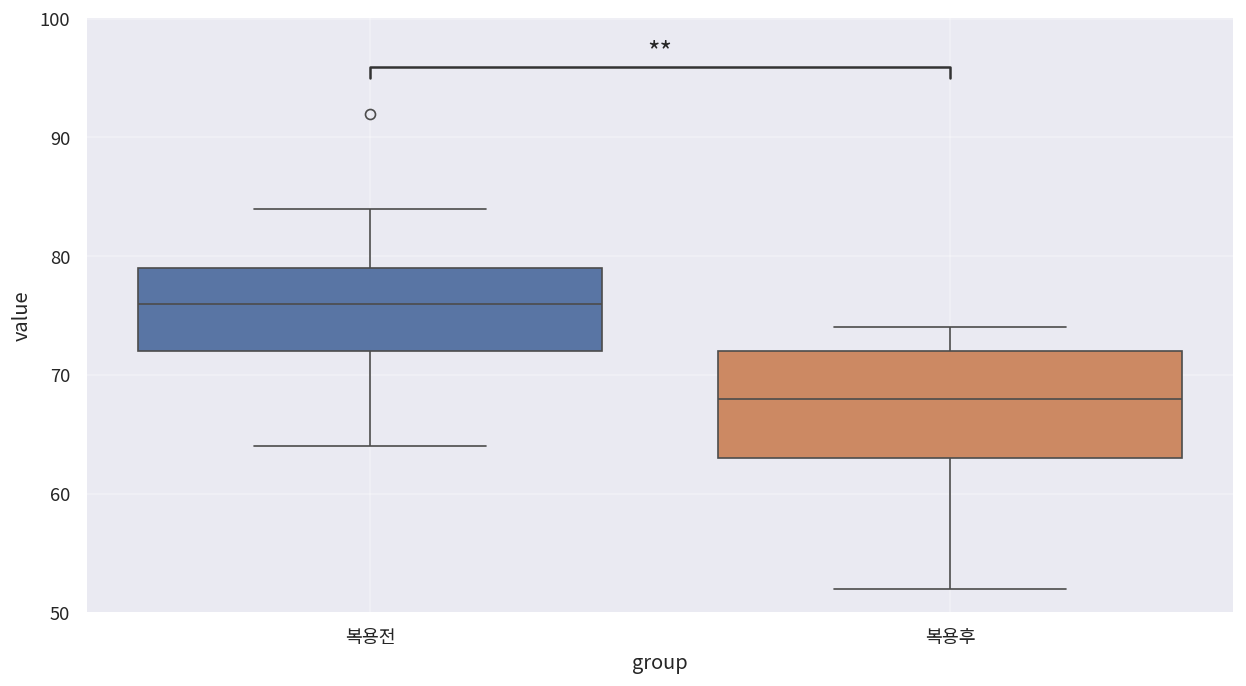

In [6]:
# 검정할 데이터 필드명
fields = ['복용전', '복용후']

# 검정 방법
#  't-test_ind', 't-test_paired', 't-test_welch', 'Mann-Whitney',
#  'Mann-Whitney-gt', 'Mann-Whitney-ls', 'Levene', 'Wilcoxon', 'Kruskal'
test_method = 't-test_paired'

# 데이터 재배치
visual_df = melt(
    origin[fields],
    value_vars=fields,
    var_name='group',
    value_name='value'
)

# 1) 그래프 초기화
width_px  = 1280              # 그래프 가로 크기
height_px = 720               # 그래프 세로 크기
rows      = 1                 # 그래프 행 수
cols      = 1                 # 그래프 열 수
figsize   = (width_px / my_dpi, height_px / my_dpi)

fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

# 2) BoxPlot 그리기
sb.boxplot(data=visual_df, x='group', y='value', hue='group')

annotator = Annotator(
    ax,
    data=visual_df,
    x='group',
    y='value',
    pairs=[fields]
)
annotator.configure(test=test_method)
annotator.apply_and_annotate()

# 3) 그래프 꾸미기
ax.grid(True, alpha=0.3)      # 배경 격자 표시

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료
